r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


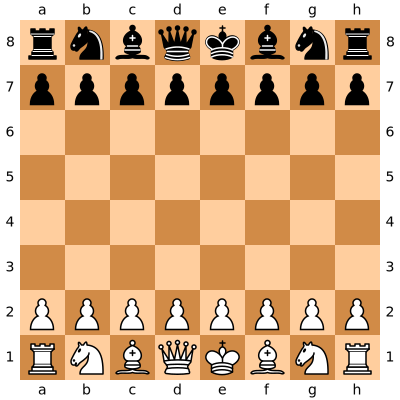

In [1]:
import sklearn.ensemble
import chess_bot
from chess_bot.utils import play_game
from chess_bot import bots
import os
import pickle

save_parent = './data/'

board = chess_bot.Board()

print(board)
board



### Have the rando bot play itsself until black and white win at least 10000 times each ###

In [2]:
if not os.path.exists(save_parent):
    os.makedirs(save_parent)

def play_games(p1, p2, n_winning_games):
    board_list = list()
    winner_list = list()

    black_won = 0
    white_won = 0
    
    while not (black_won > n_winning_games and white_won > n_winning_games):

        board = chess_bot.Board()
        final_board, turn = play_game(board, p1, p1)

    #     print(turn)
        winner = final_board.who_won()

        if winner == 0:
            black_won += 1
            print('black won')

    #         board_list.append(final_board)

        elif winner == 1:
            white_won += 1
            print('white won')

        board_list.append(final_board)
        winner_list.append(winner)

    return board_list, winner_list

p1 = bots.RandoBot()

save_path = save_parent + 'rando_games_10.p'
if not os.path.exists(save_path):
    
    board_list, winner_list = play_games(p1, p1, 10)
    
    with open( save_path, "wb" ) as f:     
        pickle.dump( [board_list, winner_list], f )

else:
    print('Loading games. This might take a while...')
    with open(save_path, 'rb') as f:
        board_list, winner_list = pickle.load(f)
        
    print('Done.')


# save_path = save_parent + 'rando_games_100.p'
# if not os.path.exists(save_path):
    
#     board_list, winner_list = play_games(p1, p1, 100)
    
#     with open( save_path, "wb" ) as f:     
#         pickle.dump( [board_list, winner_list], f )

# else:
#     print('Loading games. This might take a while...')
#     with open(save_path, 'rb') as f:
#         board_list, winner_list = pickle.load(f)
        
#     print('Done.')



# save_path = save_parent + "rando_games_10k.p"
# if not os.path.exists(save_path):
    
#     board_list, winner_list = play_games(p1, p1, 10000)
    
#     with open( save_path, "wb" ) as f:     
#         pickle.dump( [board_list, winner_list], f )

# else:
#     print('Loading old games. This might take a while...')
#     with open(save_path, 'rb') as f:
#         board_list, winner_list = pickle.load(f)
        
#     print('Done.')
    
len(board_list)

Loading games. This might take a while...
Done.


146

### Do some timing to see how long it takes to turn a few boards into vectors

In [ ]:
import time

start = time.time()
history = [board.vec_history() for board in board_list]
end = time.time()

print(end - start)

# RANDOM FOREST EXPERIMENTS

### Have a random forest bot learn from the above games ###

In [ ]:
p_bot = bots.SKLearnBot(sklearn.ensemble.RandomForestClassifier(n_estimators=100))
p_bot.train_from_board(board_list)

### Let the RF bot play itsself a few times ###

In [ ]:
# while len(train_board_list) < 500:

p_bot.state = 'wexploit'

tot_wins = 500
n_wins = 0

while n_wins < tot_wins:
    board = chess_bot.Board()
    final_board, turn = play_game(board, p_bot, p_bot)

    winner = final_board.who_won()
    
    print('winner: ' + str(winner) + ' #turns: ' + str(turn))

    if winner != 2:
        n_wins += 1
        board_list.append(final_board)
        p_bot.train_from_board(board_list)

final_board

### See if it can beat the rando bot ###

In [ ]:
p1 = bots.RandoBot()

p_bot.state = 'exploit'

board_list = list()

black_won = 0
white_won = 0

n_games = 0
while n_games < 50:

    board = chess_bot.Board()
    final_board, turn = play_game(board, p1, p_bot)

    winner = final_board.who_won()
    
    if winner == 1:
        white_won += 1
        board_list.append(final_board)

    elif winner == 0:
        black_won += 1
        board_list.append(final_board)


    print('winner: ' + str(winner) + ' #turns: ' + str(turn))
    n_games +=1
    
final_board

Nope can't beat the rando bot. Gotta try harder.

# DEEP LEARNING EXPERIMENTS

In [3]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

from chess_bot import torch_bot

save_path = save_parent + 'torch_bot.th'

model = torch_bot.TorchBot(gpu_ids = [0])


In [ ]:
model.train_from_board(board_list)
#takes about .5 sec/board

In [ ]:
board = chess_bot.Board()
model.choose_move(board)

> /root/projects/chess_bot/chess_bot/torch_bot.py(176)choose_move()
-> _, indices = torch.max(target_pred, 1)
(Pdb) target_pred
Variable containing:
-0.1466  0.1337  0.0320
-0.1929  0.1729 -0.0103
-0.1783  0.1040  0.0415
-0.1943  0.1321  0.0328
-0.1661  0.1353  0.0164
-0.1510  0.1065  0.0478
-0.1679  0.1478  0.0224
-0.1382  0.2248 -0.0062
-0.2064  0.1780  0.0001
-0.2114  0.0648  0.0602
-0.2370  0.1722  0.0792
-0.1349  0.1326  0.0193
-0.1939  0.1214  0.0570
-0.1827  0.1004  0.0544
-0.1515  0.1560  0.0165
-0.1595  0.1852 -0.0005
-0.2407  0.1897  0.0192
-0.1582  0.0712  0.1043
-0.2099  0.1928  0.0738
-0.1787  0.1010  0.0267
[torch.cuda.FloatTensor of size 20x3 (GPU 0)]

(Pdb) target_pred
Variable containing:
-0.1466  0.1337  0.0320
-0.1929  0.1729 -0.0103
-0.1783  0.1040  0.0415
-0.1943  0.1321  0.0328
-0.1661  0.1353  0.0164
-0.1510  0.1065  0.0478
-0.1679  0.1478  0.0224
-0.1382  0.2248 -0.0062
-0.2064  0.1780  0.0001
-0.2114  0.0648  0.0602
-0.2370  0.1722  0.0792
-0.1349  0.1326  0.01

In [ ]:
np.repeat(turns_array, [1, 1, 8, 8])
